In [1]:
import os
import numpy as np
import time
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.contrib import graph_editor as ge
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)
print(tf.__git_version__)

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12472952657034743275
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11992055808
locality {
  bus_id: 1
}
incarnation: 11654170773547241061
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:07:00.0"
]
0.12.head
0.12.1-1934-g27fca7d-dirty


# Benchmark transfering data from CPU to GPU

In [16]:
size_mbs = 10
n = 250*1000*size_mbs   # n of float32 entries
with tf.device("/gpu:0"):
    gpu_var = tf.Variable(tf.random_uniform((n,)))
with tf.device("/cpu:0"):
    cpu_var = tf.Variable(tf.random_uniform((n,)))

gpu_to_cpu = cpu_var.assign(gpu_var)
cpu_to_gpu = gpu_var.assign(cpu_var)

# turn off graph-rewriting
config = tf.ConfigProto(graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0)))
sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())
def benchmark(op, iters):
    start_time = time.time()
    for i in range(iters):
        sess.run(gpu_to_cpu.op)
    end_time = time.time()
    return float(end_time - start_time)

iters = 1000
gpu_to_cpu_time = benchmark(gpu_to_cpu, iters)
cpu_to_gpu_time = benchmark(cpu_to_gpu, iters)
data_volume_mbs = iters*size_mbs

transfer_rate_mbs = data_volume_mbs/gpu_to_cpu_time
print("Transfer rate gpu->cpu = %.2f GB/sec, %.2f ms/call" %(transfer_rate_mbs/1000,1000*gpu_to_cpu_time/iters))

transfer_rate_mbs = data_volume_mbs/cpu_to_gpu_time
print("Transfer rate cpu->gpu = %.2f GB/sec, %.2f ms/call" %(transfer_rate_mbs/1000,1000*cpu_to_gpu_time/iters))

Transfer rate gpu->cpu = 3.38 GB/sec, 2.96 ms/call
Transfer rate cpu->gpu = 3.31 GB/sec, 3.02 ms/call


# Fair benchmark transfering data from CPU to GPU

In [19]:
size_mbs = 10
n = 250*1000*size_mbs   # n of float32 entries
with tf.device("/gpu:0"):
    gpu_var = tf.Variable(tf.random_uniform((n,)))
    gpu_var0 = tf.Variable(tf.random_uniform((n,)))
with tf.device("/cpu:0"):
    cpu_var = tf.Variable(tf.random_uniform((n,)))

cpu_to_gpu = gpu_var.assign(cpu_var)
gpu_to_gpu = gpu_var.assign(gpu_var0)

# turn off graph-rewriting
config = tf.ConfigProto(graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0)))
sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())
def benchmark(op, iters):
    start_time = time.time()
    for i in range(iters):
        sess.run(gpu_to_cpu.op)
    end_time = time.time()
    return float(end_time - start_time)

iters = 1000
gpu_to_cpu_time = benchmark(gpu_to_gpu, iters)
cpu_to_gpu_time = benchmark(cpu_to_gpu, iters)
data_volume_mbs = iters*size_mbs

transfer_rate_mbs = data_volume_mbs/gpu_to_cpu_time
print("Transfer rate gpu->cpu = %.2f GB/sec, %.2f ms/call" %(transfer_rate_mbs/1000,1000*gpu_to_cpu_time/iters))

transfer_rate_mbs = data_volume_mbs/cpu_to_gpu_time
print("Transfer rate cpu->gpu = %.2f GB/sec, %.2f ms/call" %(transfer_rate_mbs/1000,1000*cpu_to_gpu_time/iters))

Transfer rate gpu->cpu = 3.27 GB/sec, 3.06 ms/call
Transfer rate cpu->gpu = 3.35 GB/sec, 2.98 ms/call


In [20]:
35-27

8

# Find cross-over point for mul

In [16]:
def benchmark_mul_gpu(size_mbs, iters=10):
    n = 250*1000*size_mbs   # n of float32 entries

    """Find time needed to multiply two vectors on GPU."""
    with tf.device("/gpu:0"):
        var0 = tf.Variable(tf.random_uniform((n,)))
        var1 = tf.Variable(tf.random_uniform((n,)))
        op = tf.multiply(var0, var1)
    config = tf.ConfigProto(graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0)))
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    for i in range(iters):
        if i == 1: # skip 0 as the warm-up iteration
            start_time = time.time()
        sess.run(op.op)
    end_time = time.time()
    return (end_time - start_time)/(iters-1)

In [17]:
mbs = range(10, 100, 10)
times_mul = [benchmark_mul_gpu(m) for m in mbs]

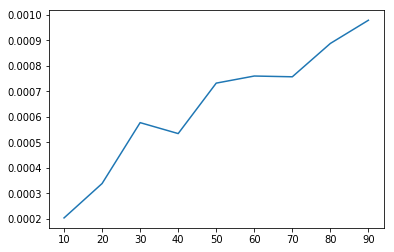

In [18]:
plt.plot(mbs, times_mul)

In [19]:
def benchmark_transfer_gpu(size_mbs, iters=10):
    n = 250*1000*size_mbs   # n of float32 entries
    with tf.device("/gpu:0"):
        gpu_var = tf.Variable(tf.random_uniform((n,)))
        gpu_var0 = tf.Variable(tf.random_uniform((n,)))
    with tf.device("/cpu:0"):
        cpu_var = tf.Variable(tf.random_uniform((n,)))

    cpu_to_gpu = gpu_var.assign(cpu_var)
    gpu_to_gpu = gpu_var.assign(gpu_var0)

    # turn off graph-rewriting
    config = tf.ConfigProto(graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0)))
    sess = tf.Session(config=config)

    sess.run(tf.global_variables_initializer())
    def benchmark(op, iters):
        for i in range(iters):
            if i == 1: # skip 0 as the warm-up iteration
                start_time = time.time()
            sess.run(op)
        end_time = time.time()
        return float(end_time - start_time)/(iters-1)

    gpu_to_gpu_time = benchmark(gpu_to_gpu.op, iters)
    cpu_to_gpu_time = benchmark(cpu_to_gpu.op, iters)
    overhead = cpu_to_gpu_time - gpu_to_gpu_time
    return overhead

In [20]:
mbs = range(10, 100, 10)
times_transfer = [benchmark_transfer_gpu(m) for m in mbs]

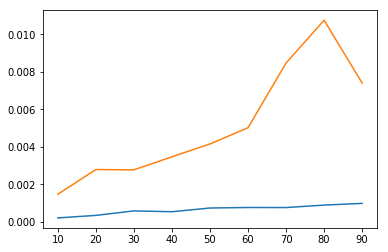

In [21]:
plt.plot(mbs, times_mul, mbs, times_transfer)

# Find cross-over point for concat

In [22]:
def benchmark_concat_gpu(size_mbs, iters=10):
    n = 250*1000*size_mbs   # n of float32 entries

    """Find time needed to multiply two vectors on GPU."""
    with tf.device("/gpu:0"):
        var0 = tf.Variable(tf.random_uniform((n//2,)))
        var1 = tf.Variable(tf.random_uniform(((n+1)//2,)))
        op = tf.concat_v2(values=[var0, var1], axis=0)
    config = tf.ConfigProto(graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0)))
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    for i in range(iters):
        if i == 1: # skip 0 as the warm-up iteration
            start_time = time.time()
        sess.run(op.op)
    end_time = time.time()
    return (end_time - start_time)/(iters-1)

In [23]:
mbs = range(10, 100, 10)
times_concat = [benchmark_concat_gpu(m) for m in mbs]

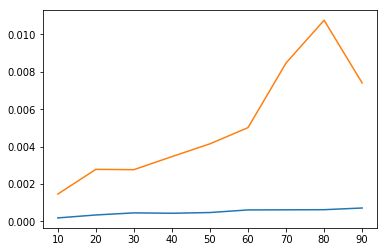

In [24]:
plt.plot(mbs, times_concat, mbs, times_transfer)

In [25]:
times_concat

[0.0001904169718424479,
 0.0003476672702365451,
 0.0004597240024142795,
 0.0004393524593777127,
 0.0004779232872856988,
 0.0006171597374810113,
 0.0006229612562391493,
 0.0006300873226589627,
 0.0007197062174479166]

In [26]:
times_mul

[0.00020395384894476997,
 0.0003387928009033203,
 0.0005774762895372179,
 0.0005345874362521701,
 0.0007323424021402994,
 0.0007601843939887153,
 0.0007571909162733289,
 0.0008879502614339193,
 0.0009788672129313152]

In [31]:
times_transfer

[0.0014644463857014973,
 0.0027846495310465498,
 0.0027686225043402775,
 0.0034654935201009116,
 0.0041493839687771275,
 0.005014763938056098,
 0.008468733893500434,
 0.01075116793314616,
 0.0073994530571831595]

In [30]:
1000*np.array([times_transfer[-1], times_mul[-1], times_concat[-1]])

array([ 7.39945306,  0.97886721,  0.71970622])

In [ ]:
1000*np.array([times_transfer[-1], times_mul[-1], times_concat[-1]])

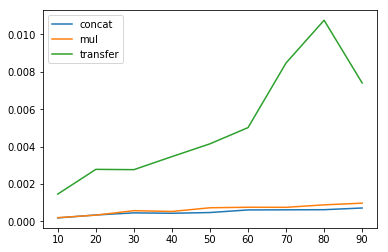

In [40]:
plt.plot(mbs, times_concat, label="concat")
plt.plot(mbs, times_mul, label="mul")
plt.plot(mbs, times_transfer, label="transfer")
plt.legend()